<a href="https://colab.research.google.com/github/MRsources/MRzero-Core/blob/main/documentation/playground_mr0/unsorted/Pulseq_2D_density_adapted_radial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2D density adapted radial GRE after Konstandin et al. 2011 [1]


[1] Konstandin, Simon & Nagel, Armin & Heiler, Patrick & Schad, Lothar. (2011). Two-Dimensional Radial Acquisition Technique With Density Adaption in Sodium MRI. Magnetic resonance in medicine : official journal of the Society of Magnetic Resonance in Medicine / Society of Magnetic Resonance in Medicine. 65. 1090-6. 10.1002/mrm.22684.



In [ ]:
!pip install pypulseq==1.3.1.post1 &> /dev/null
!pip install MRzeroCore &> /dev/null
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/subject05.npz &> /dev/null
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null

/usr/local/lib/python3.10/dist-packages/pypulseq/Sequence/block.py:86: UserWarning: Warning: converting a masked element to nan.
  check_g[channel_num].stop = np.array(
/usr/local/lib/python3.10/dist-packages/pypulseq/event_lib.py:51: UserWarning: Warning: converting a masked element to nan.
  new_data = np.array(new_data)
/usr/local/lib/python3.10/dist-packages/pypulseq/event_lib.py:77: UserWarning: Warning: converting a masked element to nan.
  new_data = np.array(new_data)


Timing check passed successfully


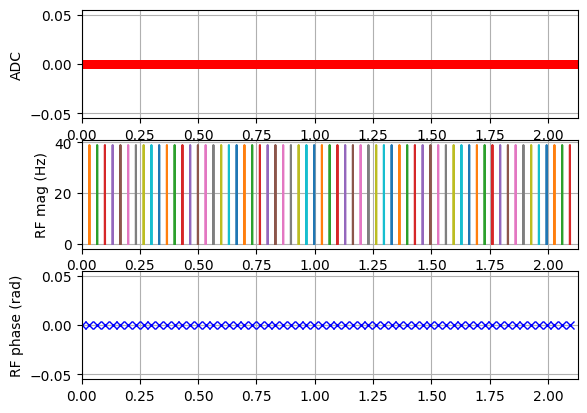

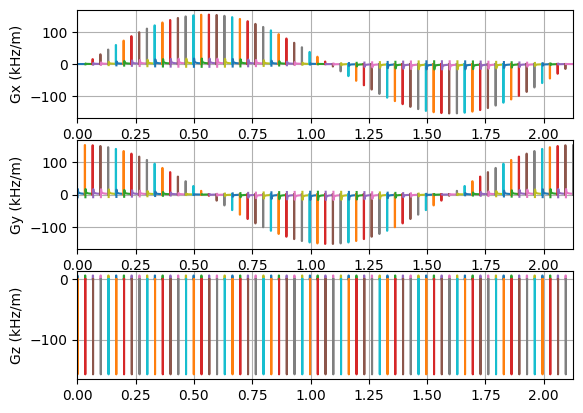

VoxelGridPhantom
size = tensor([0.2000, 0.2000, 0.0080])


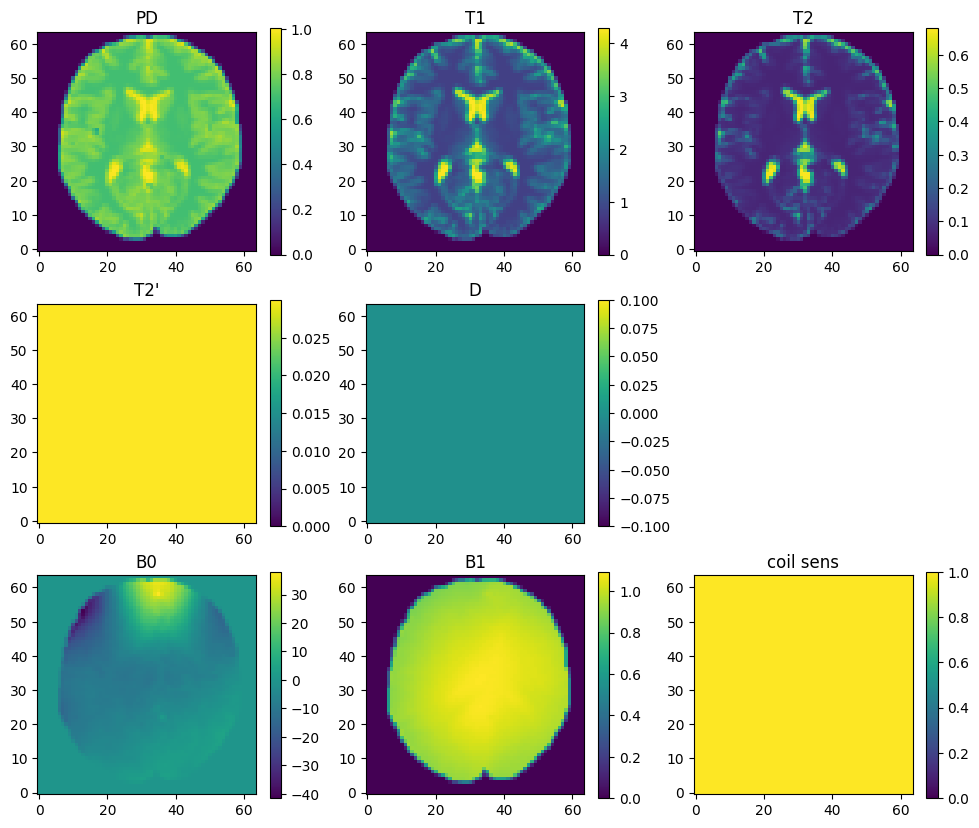

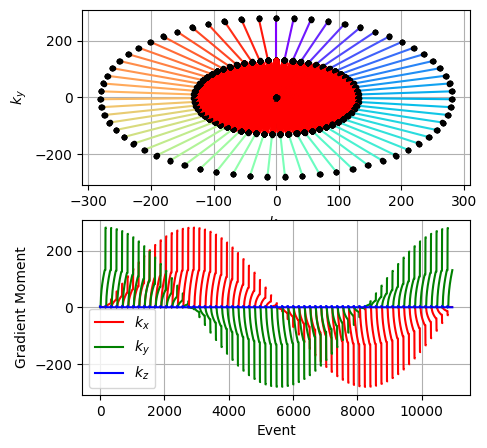

Calculating repetition 64 / 64 - done


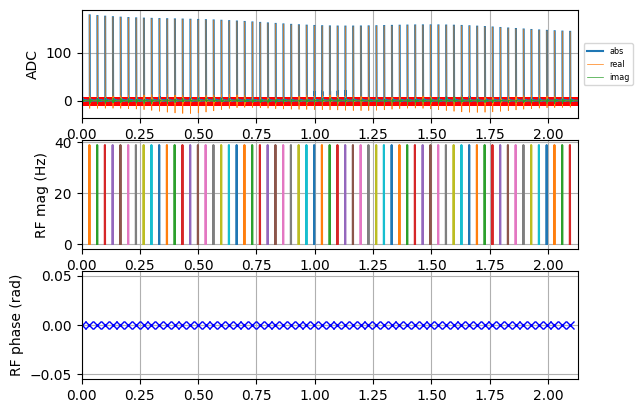

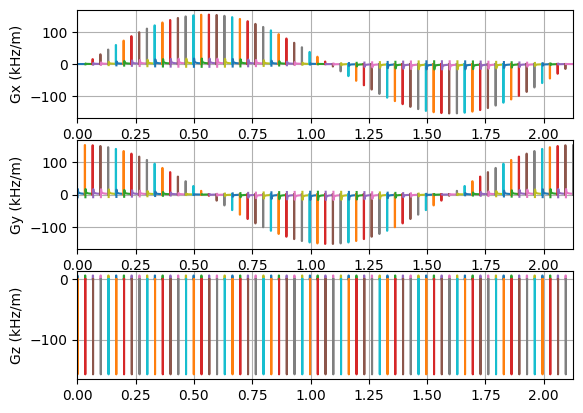

> NUFFT recon with density compensation function
torch.Size([1, 1, 8192]) should be: [batch_size, num_coils,num_samples]
torch.Size([8192]) should be: [num_samples]
nufft_adj -> image shape:  torch.Size([1, 1, 64, 64])


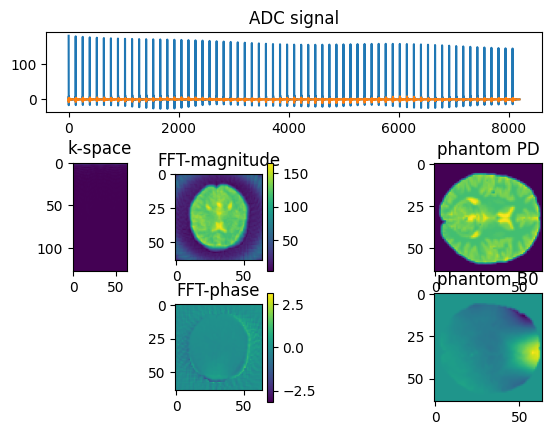

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Wed Mar  6 21:11:50 2024

@author: Jordan.Hoehn@uk-erlangen.de
"""

import MRzeroCore as mr0
import pypulseq as pp
import numpy as np
import torch
from matplotlib import pyplot as plt
# makes the ex folder your working directory
import os

experiment_id = '2D_DA_RAD_GA'
#k = [1/m]
#k_max = nsamp / (fov * 2)
# %% S1. SETUP sys

# choose the scanner limits
system = pp.Opts(
    max_grad=28, grad_unit='mT/m', max_slew=200, slew_unit='T/m/s',
    rf_ringdown_time=20e-6, rf_dead_time=100e-6,
    adc_dead_time=20e-6
)


gamma = system.gamma

#%%Init Var

fov = 200e-3
dpx = 5e-3
#k_max = 1/(dpx)
d_slice = 8e-3
#n_p = int(np.pi*(fov/dpx))+1 #Nyquist for resolution
n_p = 64
n_samp = 128
#k_max = n_samp/2
k_max = 1/(2*dpx)
TR = 20e-3
TE = 1e-3


t0 = 1.0e-3
t_gr = system.grad_raster_time
G0 = 2
max_slew = system.max_slew/gamma * 1e3

t_ramp = G0/max_slew
t_flat = t0 - t_ramp
A_ramp = 0.5 * G0 * t_ramp
A_flat = G0 * t_flat

k0 = A_ramp + A_flat
t_dense = (k_max**2 - 2*k0*k_max)/(2*gamma*k0*G0)

gr_sampr = int(t_ramp/t_gr)
if gr_sampr == 0:
    gr_sampr = 5
gr_sampf = int(t_flat/t_gr)
gr_sampd = int(t_dense/t_gr)
t_r = np.linspace(0, t_ramp, num=gr_sampr)
t_f = np.ones(gr_sampf)
t_d = np.linspace(0, t_dense, num=gr_sampd)

#G = np.zeros_like(t_grad)
G_r = max_slew*t_r
G_f = G0*t_f
G_d = k0*G0/np.sqrt(k0**2 + 2*k0*G0*(t_d))

t_RO = t0 + t_dense

t_rampdown = G_d[-1]/max_slew
gr_samprd = int(t_rampdown/t_gr)
if gr_samprd == 0:
    gr_samprd = 10
t_rd = np.linspace(0, t_rampdown, num=gr_samprd)
G_rd = -max_slew * t_rd
G_rd[-1] = 0

G = np.concatenate((G_r, G_f))
G = np.concatenate((G, G_d))
G = np.concatenate((G, G_rd))
t_grad = np.linspace(0, (t0+t_dense+t_rampdown), num=len(G))


G = G * gamma*1e-3
G = np.ma.masked_less(G, 0)

#fig = plt.Figure()
#plt.plot(t_grad,G)



#%%
GA = 0
golden_ratio = 1.618
if GA:
    x = np.arange(0,n_p)
    theta = np.mod(2*np.pi - 2*np.pi/golden_ratio * x, 2*np.pi)
else:
    theta = np.linspace(0,2*np.pi, n_p)

# %% Pulse initialization/ Gradients
seq = pp.Sequence(system)


rf, gz, gzr = pp.make_sinc_pulse(
                        flip_angle=7*np.pi/180,
                        duration=1e-3,
                        slice_thickness=d_slice,
                        time_bw_product=50e-3,
                        apodization=0.5,
                        system=system,
                        return_gz=True
                        )

c_rf = pp.calc_rf_center(rf)
delay_TE = TE - rf.ringdown_time - c_rf[0]

if delay_TE <= 0:
    print('Echotime is to short delay between RF and GRAD will be set to 0.')

adc = pp.make_adc(num_samples=n_samp, duration=t_RO, phase_offset=0 * np.pi / 180, delay=0, system=system)



for i in range(n_p):

    Gx = pp.make_arbitrary_grad.make_arbitrary_grad(channel='x', waveform=G*np.sin(theta[i])*fov, system=system,)
    Gy = pp.make_arbitrary_grad.make_arbitrary_grad(channel='y', waveform=G*np.cos(theta[i])*fov, system=system,)

    Gx_spoil = pp.make_trapezoid(channel='x', area=1.5*k_max*np.sin(theta[i]), duration=1e-3, system=system)
    Gy_spoil = pp.make_trapezoid(channel='y', area=1.5*k_max*np.cos(theta[i]), duration=1e-3, system=system)
    seq.add_block(rf, gz)
    seq.add_block(gzr)
    if delay_TE > 0:
        seq.add_block(pp.make_delay(delay_TE))
    seq.add_block(Gy, Gx, adc)
    seq.add_block(Gx_spoil, Gy_spoil)
    delay_TR = TR-pp.calc_duration(Gx) - pp.calc_duration(Gx_spoil) - pp.calc_duration(gzr)
    if delay_TR > 0:
        seq.add_block(pp.make_delay(delay_TR))

# %% S3. CHECK, PLOT and WRITE the sequence  as .seq
# Check whether the timing of the sequence is correct
ok, error_report = seq.check_timing()
if ok:
    print('Timing check passed successfully')
else:
    print('Timing check failed. Error listing follows:')
    [print(e) for e in error_report]

# PLOT sequence
sp_adc, t_adc = mr0.util.pulseq_plot(seq, clear=False, figid=(11,12))

# Prepare the sequence output for the scanner
seq.set_definition('FOV', [fov, fov, d_slice])
seq.set_definition('Name', 'gre')
seq.write('external.seq')
seq.write(experiment_id + '.seq')


# %% S4: SETUP SPIN SYSTEM/object on which we can run the MR sequence external.seq from above
sz = [64, 64]

if 1:
    # (i) load a phantom object from file
    obj_p = mr0.VoxelGridPhantom.load_mat('numerical_brain_cropped.mat')
    obj_p = obj_p.interpolate(sz[0], sz[1], 1)

# Manipulate loaded data
    obj_p.T2dash[:] = 30e-3
    obj_p.D *= 0
    obj_p.B0 *= 1    # alter the B0 inhomogeneity
    # Store PD and B0 for comparison
    PD = obj_p.PD.squeeze()
    B0 = obj_p.B0.squeeze()
else:
    # or (ii) set phantom  manually to a pixel phantom. Coordinate system is [-0.5, 0.5]^3
    obj_p = mr0.CustomVoxelPhantom(
        pos=[[-0.4, -0.4, 0], [-0.4, -0.2, 0], [-0.3, -0.2, 0], [-0.2, -0.2, 0], [-0.1, -0.2, 0]],
        PD=[1.0, 1.0, 0.5, 0.5, 0.5],
        T1=1.0,
        T2=0.1,
        T2dash=0.1,
        D=0.0,
        B0=0,
        voxel_size=0.1,
        voxel_shape="box"
    )
    # Store PD for comparison
    PD = obj_p.generate_PD_map()
    B0 = torch.zeros_like(PD)

obj_p.plot()
obj_p.size=torch.tensor([fov, fov, d_slice])
# Convert Phantom into simulation data
obj_p = obj_p.build()


# %% S5:. SIMULATE  the external.seq file and add acquired signal to ADC plot

# Read in the sequence
seq0 = mr0.Sequence.import_file("external.seq")

seq0.plot_kspace_trajectory()
kspace_loc = seq0.get_kspace()
# Simulate the sequence
graph = mr0.compute_graph(seq0, obj_p, 200, 1e-3)
signal = mr0.execute_graph(graph, seq0, obj_p)

# PLOT sequence with signal in the ADC subplot
plt.close(11);plt.close(12)
sp_adc, t_adc = mr0.util.pulseq_plot(seq, clear=False, signal=signal.numpy())

kspace_adc = torch.reshape((signal), (n_p, n_samp)).clone().t()

# %% S6:. NUFFT reconstruction with density compensation
# Zhengguo Tan <zhengguo.tan@gmail.com>

fig = plt.figure()  # fig.clf()
plt.subplot(411)
plt.title('ADC signal')
plt.plot(torch.real(signal), label='real')
plt.plot(torch.imag(signal), label='imag')
print('> NUFFT recon with density compensation function')

import torchkbnufft as tkbn
img_shape = [n_p] * 2

# prepare k-space trajectory traj
traj = kspace_loc[:, :2].T  # tkbn assumes xy in the first dim, thus .T
traj = traj / n_samp * np.pi # normalize k-space trajectory from -kmax to kmax to -pi to pi for tkbn
#traj = traj / n_samp * np.pi * 2 Check the min and max Values!!!
if 0:# compute density compensation function manually
    dcf = (traj[0,:]**2 + traj[1,:]**2)**0.5 # density compensation factor
    print(dcf.shape,'should be: [num_samples]')
else:# calculate density compensation function using  tkbn.calc_density_compensation_function
    dcf = tkbn.calc_density_compensation_function(ktraj=traj, im_size=img_shape)
    print(dcf.shape,'should be: [batch_size, num_coils,num_samples]')

# prepare kdat
kdat = signal.squeeze()
print(kdat.shape,'should be: [num_samples]') # should be num_samples

# Reshape kdat and dcf: (1, 1, num_samples) -> (batch_size, num_coils, num_samples) for adjoint
kdat = kdat.reshape(1, 1, -1)
dcf = dcf.reshape(1, 1, -1)

# define nufft adjoint operator
nufft_adj = tkbn.KbNufftAdjoint(im_size=img_shape)
recon_nufft = nufft_adj(kdat*dcf , traj)

print('nufft_adj -> image shape: ', recon_nufft.shape)

space = recon_nufft.numpy().squeeze()
space = np.flip(np.swapaxes(space, -1, -2), -2)

plt.subplot(345)
plt.title('k-space')
plt.imshow(np.abs(kspace_adc))

plt.subplot(346)
plt.title('FFT-magnitude')
plt.imshow(np.abs(space))
plt.colorbar()
plt.subplot(3, 4, 10)
plt.title('FFT-phase')
plt.imshow(np.angle(space), vmin=-np.pi, vmax=np.pi)
plt.colorbar()

# % compare with original phantom obj_p.PD
plt.subplot(348)
plt.title('phantom PD')
plt.imshow(PD)
plt.subplot(3, 4, 12)
plt.title('phantom B0')
plt.imshow(B0)




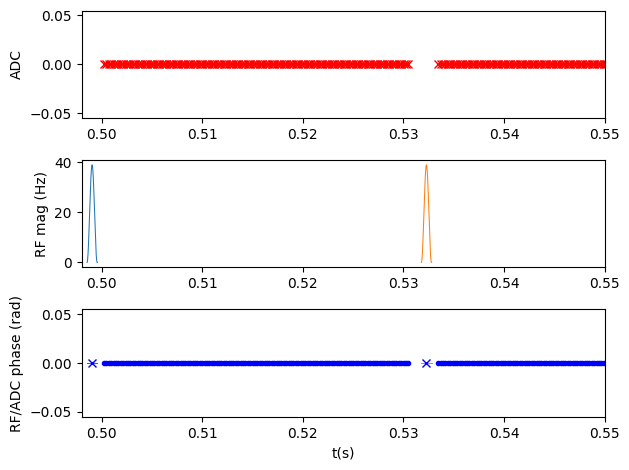

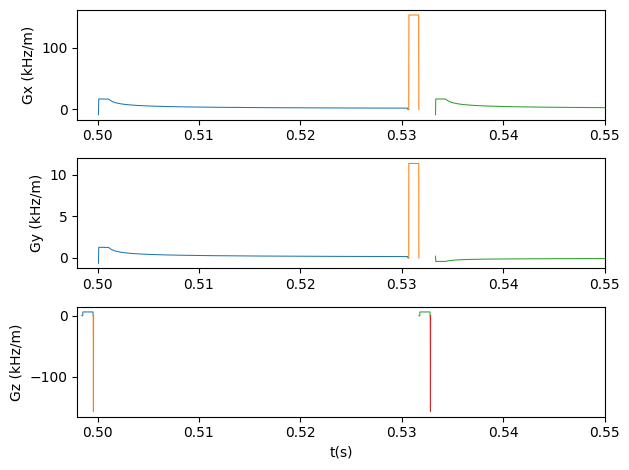

In [ ]:
seq.plot(time_range=[0.498,0.55])